# GoogLeNet with PyTorch

-------------
## Importing Packages

In [1]:
from __future__ import division

import warnings
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
import torchvision
from torchvision import transforms
import torch.optim as optim
import os

-----
## GPU Device Configuration

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


-----
## Hyperparameters

In [5]:
learning_rate = 0.0001
trainingBatch = 70
testBatch = 70
n_epochs = 15
outputDirectory = "modelSaved"

Creating a directory to save the model

In [6]:
if not os.path.exists(outputDirectory):   
    os.makedirs(outputDirectory)

-----
##  Data Loading

### Importing Libraries

In [7]:
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.datasets as dset
import torch.utils.data as data
from ipywidgets import IntProgress

###  Image processing

In [8]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

-----
### Downloading Data
Downloading data and creating training and testing splits

In [9]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=trainingBatch, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=testBatch, shuffle=False)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


-----
#  Creating Network

Defining an inception class and using it to create a GoogLeNet class.

------
# Inception Module

Creating an inception block class. The __init__ function requires 7 arguments as inputs and implements 4 blocks consisting of convolutions, normalization, max pooling, and ReLu activation functions. The forward function takes the data as input and concatenates the ouput of the 4 blocks.

In [10]:
class inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        
        super(inception, self).__init__()
        
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size = 1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True)
        )


        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size = 1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
            
            nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True)
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, padding = 1, stride = 1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True)
        )
            
    def forward(self, x):
        
        output = torch.cat([self.b1(x),self.b2(x),self.b3(x),self.b4(x)],1)
        
        return output
        

-----
## GoogLeNet Module 

In [11]:
class GoogLeNet(nn.Module):
    def __init__(self):
        
        super(GoogLeNet, self).__init__()
        
        self.c1 = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(192),
            nn.ReLU(True)
        )
          
        self.i3a = inception(192,64,96,128,16,32,32)
        self.i3b = inception(256,128,128,192,32,96,64)
        self.m1 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.i4a = inception(480,192,96,208,16,48,64)
        self.i4b = inception(512,160,112,224,24,64,64)
        self.i4c = inception(512,128,128,256,24,64,64)
        self.i4d = inception(512,112,144,288,32,64,64)
        self.i4e = inception(528,256,160,320,32,128,128)
        self.m2 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.i5a = inception(832,256,160,320,32,128,128)
        self.i5b = inception(832,384,192,384,48,128,128)
        
        self.avg = nn.AvgPool2d(8, stride = 1)
        self.fc = nn.Linear(1024,10)
    
    def forward(self, x):
        output = self.c1(x)
        
        output = self.i3a(output)
        output = self.i3b(output)
        
        output = self.m1(output)
        
        output = self.i4a(output)
        output = self.i4b(output)
        output = self.i4c(output)
        output = self.i4d(output)
        output = self.i4e(output)
        output = self.m2(output)
                
        output = self.i5a(output)
        output = self.i5b(output)
        
        output = self.avg(output)
        
        output = output.view(output.size(0),-1)
        output = self.fc(output)
        
        return output
        
    

## Creating Network
Creating the model and sending it to the target device.

In [12]:
model = GoogLeNet()
model.to(device)

GoogLeNet(
  (c1): Sequential(
    (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (i3a): inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum

## Creating Optimizer
The optimizer used to train this model is the Adam optimizer. The criterion used is cross entropy loss. The scheduler is used to decay the learning rate of each parameter group.

In [13]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

-----
##  Training Module

trainModel( ) trains the network and returns the training loss, the number of correctly predicted labels, and the total amount of data in that iteration.

In [14]:
def trainModel():
    
    # training model
    model.train()
    
    # initializing variables
    trainingLoss = 0
    correctLabels = 0
    totalData = 0
    
    # iterating through data 
    for i, (X,y) in enumerate(train_loader):
        
        # sending data and label to device
        X = X.to(device)
        y = y.to(device)
        
        # resetting the gradient of the optimizer
        optimizer.zero_grad()
        
        # feed forward
        result = model(X)
        
        # getting the prediction of the model
        n, predictedLabel = torch.max(result.data,1)
        
        # computing loss
        currentLoss = criterion(result, y)
        
        # backpropagating loss
        currentLoss.backward()
        
        optimizer.step()
        
        # adding the current loss term to the cumulative training loss
        trainingLoss += currentLoss.data
        
        # incrementing the total amount of data
        totalData += y.size(0)
        
        # counting correctly predicted labels
        correct = (y == predictedLabel).sum()
        
        # updating total amount of correct predictions accordingly 
        correctLabels += correct
    
    return trainingLoss, correctLabels, totalData

-------
## Testing Module

testModel( ) is a funciton that tests the network and returns the testing loss, the number of correctly predicted labels, and the total amount of data in that iteration.

In [15]:
def testModel():
    
    # evaluating model
    model.eval()
    
    # initializing variables
    testLoss = 0
    correctLabels = 0
    totalData = 0
    
    with torch.no_grad():
        for i, (X,y) in enumerate(test_loader):
            
            # sending data and labels to device
            X = X.to(device)
            y = y.to(device)

            # feed forward 
            result = model(X)
            
            # get prediction
            n, predictedLabel = torch.max(result.data,1)

            # compute testing loss
            currentLoss = criterion(result, y)
            
            # add current lost to total testing lost
            testLoss += currentLoss.data

            # incrementing total data 
            totalData += y.size(0)

            # counting correctly predicted labels
            correct = (y == predictedLabel).sum()
            
            # updating total amount of correct predictions
            correctLabels += correct
        
    return testLoss, correctLabels, totalData

-----
# Training and Testing Network

In [ ]:
# initializing variables to store training and testing loss and accuracy

trainingLosses = []
trainingAccuracies = []

testLosses = []
testAccuracies = []

# iterate through number of epochs
for epoch in range(n_epochs):
    
    # training model
    trainingResult = trainModel() 
    
    # getting training loss from result
    trainingLoss = trainingResult[0]
    
    # calculating training accuracy 
    trainingAccuracy = (trainingResult[1].item()/trainingResult[2])*100
    
    # printing training results
    print("Epoch ", epoch)
    print("Training loss: {}".format(trainingLoss))
    print("Training Accuracy: ", trainingAccuracy)
    
    # stepping scheduler 
    scheduler.step() 
    
    # testing model
    testResult = testModel()
    testLoss = testResult[0]
    
    # calculating testing accuracy
    testAccuracy = (testResult[1].item()/testResult[2])*100
    
    # printing testing results
    print("Testing loss: {}".format(testLoss))
    print("Testing Accuracy: ", testAccuracy)
    
    # saving training/testing accuracy and losses
    trainingLosses.append(trainingLoss)
    trainingAccuracies.append(trainingAccuracy)
    testLosses.append(testLoss)
    testAccuracies.append(testAccuracy)
    
    print()

### Saving Model

In [17]:
torch.save(model.state_dict(),"modelSaved/model.pth")

--------

# Visualizing Results

In [18]:
import matplotlib.pyplot as plt

### Visualizing Training and Testing Loss

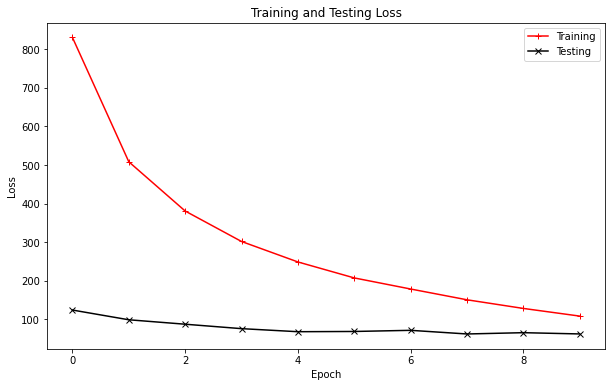

In [20]:
c = np.arange(0,10)

plt.figure(figsize = [10,6])

plt.plot(c,trainingLosses, marker = "+",color = "r")
plt.plot(c,testLosses, marker = "x", color = "k")
plt.title("Training and Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(("Training","Testing"))
plt.show()

In [25]:
print("Least Training Loss: {}".format(min(trainingLosses)))
print("Least Testing Loss: {}".format(min(testLosses)))

Least Training Loss: 108.23265838623047
Least Testing Loss: 61.86983108520508


Training loss converged at around 2-3 by the halfway point, epoch 25. The lowest training loss was 2.369 which was at epoch 41. Testing loss converged at around 45 by the 10th epoch. The least testing loss was 40.929 which was at epoch 11.

### Visualizing Training and Testing Accuracy

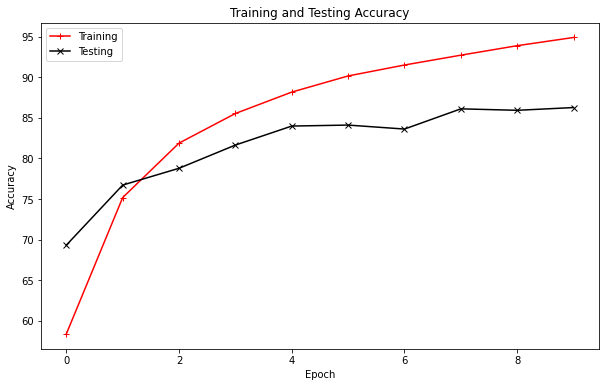

In [22]:
c = np.arange(0,10)

plt.figure(figsize = [10,6])

plt.plot(c,trainingAccuracies, marker = "+",color = "r")
plt.plot(c,testAccuracies, marker = "x", color = "k")
plt.title("Training and Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(("Training","Testing"))
plt.show()

In [24]:
print("Highest Training Accuracy: {}".format(max(trainingAccuracies)))
print("Highest Testing Accuracy: {}".format(max(testAccuracies)))

Highest Training Accuracy: 94.892
Highest Testing Accuracy: 86.26


In [ ]:
testImage = test_set[0]
print(testImage)
testLoad = torch.utils.data.DataLoader(dataset=testImage, batch_size=1, shuffle=False)
for X in testLoad:
    print(X)
    print(model(X))

Training accuracy converged at around 99% at apoch 15-20. The highest training accuracy was 99.998% which occured in epoch 37. Testing accuracy converged at around 91% starting from epoch 12. The highest testing accuracy was 91.61% from epoch 38.